In [ ]:
#pip install lightgbm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
  
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score,RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint as sp_randint
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import scipy.stats as stats
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import recall_score, f1_score, confusion_matrix, classification_report, accuracy_score,precision_score, roc_auc_score

In [2]:
df=pd.read_csv('Diabetes_Cleaned.csv')
df.head()

race  gender  age discharge_disposition_id admission_source_id  \
0        Caucasian       0    5            Not Available            Referral   
1        Caucasian       0   15       Discharged to home           Emergency   
2  AfricanAmerican       0   25       Discharged to home           Emergency   
3        Caucasian       1   35       Discharged to home           Emergency   
4        Caucasian       1   45       Discharged to home           Emergency   

   time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
0                 1                  41               0                1   
1                 3                  59               0               18   
2                 2                  11               5               13   
3                 2                  44               1               16   
4                 1                  51               0                8   

                                        diag_1  ... glipizide glyburide  \
0                                     Diabetes  ...        -2        -2   
1  Endocrine, Nutritional, Metabolic, Immunity  ...        -2        -2   
2                        Pregnancy, Childbirth  ...         0        -2   
3                     Infectious and Parasitic  ...        -2        -2   
4                                    Neoplasms  ...         0        -2   

   pioglitazone rosiglitazone insulin  diabetesMed  readmitted  \
0            -2            -2      -2            0           0   
1            -2            -2       1            1           0   
2            -2            -2      -2            1           0   
3            -2            -2       1            1           0   
4            -2            -2       0            1           0   

   preceding_year_visits  number_changes  insulin_treatment  
0                      0             0.0             no_med  
1                      0             1.0       insulin_only  
2                      3             0.0         other_meds  
3                      0             1.0       insulin_only  
4                      0             0.0      insulin_combo  

[5 rows x 28 columns]

### Baseline Model

In [3]:
X = df.drop('readmitted', 1)
y = df['readmitted']

C:\Users\abhya\AppData\Local\Temp\ipykernel_25164\766821008.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop('readmitted', 1)


In [4]:
X_dum = pd.get_dummies(X, drop_first = True)
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size = 0.3, random_state = 0, stratify = y)
X_train.shape, X_test.shape

((67949, 95), (29121, 95))

In [5]:
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state = 0, n_jobs = -1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_train_prob = rf.predict_proba(X_train)[:, 1]
y_test_pred = rf.predict(X_test)
y_test_prob = rf.predict_proba(X_test)[:, 1]

print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Train Accuracy Score: 0.9999411323198281
Train Confusion Matrix:
 [[60165     0]
 [    4  7780]] 

Train F1 Score: 0.9997429966589566
Train Precision Score: 1.0
Train Recall Score: 0.9994861253854059
Train ROC_AUC Score: 0.999999998932364

Test Accuracy Score: 0.8855465128257958
Test Confusion Matrix:
 [[25778     7]
 [ 3326    10]] 

Test F1 Score: 0.005964807634953773
Test Precision Score: 0.5882352941176471
Test Recall Score: 0.002997601918465228
Test ROC_AUC Score: 0.6344802982512187


In [7]:
pip install svm

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for svm: filename=svm-0.1.0-py3-none-any.whl size=3466 sha256=f98c1cba3bb3e4770058e68c615586268c2a5809d035ea98c2aea785ed1c5eae
  Stored in directory: c:\users\abhya\appdata\local\pip\cache\wheels\38\1e\67\e4fe09dd9a91d94fb9f7cadee4199cfd8f5616a66359c7e733
Successfully built svm
Note: you may need to restart the kernel to use updated packages.


It is clear that there is overfitting and recall is very low in test results. The main cause is the class imbalance present in our data. 

In [8]:
models = []

models.append(('LR', Pipeline([("Transformer", PowerTransformer()),
                               ("Scaler", StandardScaler()),
                              ("LogReg", LogisticRegression(random_state = 0, solver = 'liblinear'))])))
models.append(('DT', DecisionTreeClassifier(random_state = 0)))
models.append(('RF', RandomForestClassifier(random_state = 0, n_jobs = -1)))
models.append(('ADA',AdaBoostClassifier(random_state = 0)))
models.append(('XGB', XGBClassifier(random_state = 0, n_jobs = -1)))
models.append(('LGB',LGBMClassifier(random_state = 0, n_jobs = -1)))
#models.append(('SVC', Pipeline([("Transformer", PowerTransformer()),
#                                ("Scaler", StandardScaler()),
#                                ("SVC", SVC(random_state = 0, probability=True))])))



## Validation Set Scores
precision = []
recall = []
names = []
f1 = []
accuracy = []
roc_auc = []
Training_Time=[]
Prediction_Time=[]

for name, model in models:
    start_time = time.time()    
    model.fit(X_train, y_train)
    end_time = time.time()
    Training_Time.append(end_time - start_time)
    
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    Prediction_Time.append(end_time-start_time)
    
    y_proba = model.predict_proba(X_test)[:, 1]
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    accuracy.append(accuracy_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_proba))
    names.append(name)
models_df = pd.DataFrame({'Model' : names, 'Precision' : precision, 'Recall' : recall,
                          'F1' : f1, 'Accuracy' : accuracy, 'ROC_AUC' : roc_auc,
                          'Training_Time':Training_Time,'Prediction_Time':Prediction_Time})
models_df

Model  Precision    Recall        F1  Accuracy   ROC_AUC  Training_Time  \
0    LR   1.000000  0.000300  0.000599  0.885478  0.650394       7.839325   
1    DT   0.157147  0.172362  0.164403  0.799286  0.526379       2.111160   
2    RF   0.588235  0.002998  0.005965  0.885547  0.634480       2.405065   
3   ADA   0.500000  0.000600  0.001198  0.885443  0.656087       7.237488   
4   XGB   0.412281  0.014089  0.027246  0.884757  0.644734       3.451359   
5   LGB   0.750000  0.007194  0.014252  0.885993  0.662820       0.476731   

   Prediction_Time  
0         0.111664  
1         0.036472  
2         0.169767  
3         0.588117  
4         0.031739  
5         0.042603

In [9]:
df['readmitted'].value_counts(1)*100

0    88.544349
1    11.455651
Name: readmitted, dtype: float64

The Imbalance Ratio of our dataset was 1: 8. This may lead to treating features of the minority class as noise. Thus, there is a high probability of misclassification of the minority class as compared to the majority class.
Keeping in mind the disadvantages of oversampling and undersampling techniques, we have used cost sensitive algorithms to deal with class imbalance


### With Class Weights


In [10]:
models = []

models.append(('LR', Pipeline([("Transformer", PowerTransformer()),
                               ("Scaler", StandardScaler()),
                               ("LogReg", LogisticRegression(random_state = 0, solver = 'liblinear', n_jobs = -1,class_weight='balanced'))])))
models.append(('DT', DecisionTreeClassifier(random_state = 0,class_weight='balanced')))
models.append(('RF', RandomForestClassifier(random_state = 0, n_jobs = -1,class_weight ='balanced_subsample')))
models.append(('XGB', XGBClassifier(random_state = 0, n_jobs = -1,scale_pos_weight=7.72)))
models.append(('LGB',LGBMClassifier(random_state = 0, n_jobs = -1,class_weight ='balanced')))
#models.append(('SVC', Pipeline([("Transformer", PowerTransformer()),
#                               ("Scaler", StandardScaler()),
#                               ("SVM", SVC(random_state = 0,class_weight='balanced', probability=True)))])))


## Validation Set Scores
precision = []
recall = []
names = []
f1 = []
accuracy = []
roc_auc = []
Training_Time=[]
Prediction_Time=[]

for name, model in models:
    start_time = time.time()    
    model.fit(X_train, y_train)
    end_time = time.time()
    Training_Time.append(end_time - start_time)
    
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    Prediction_Time.append(end_time-start_time)
    
    y_proba = model.predict_proba(X_test)[:, 1]
    precision.append(precision_score(y_test, y_pred))
    recall.append(recall_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred))
    accuracy.append(accuracy_score(y_test, y_pred))
    roc_auc.append(roc_auc_score(y_test, y_proba))
    names.append(name)
models_df = pd.DataFrame({'Model' : names, 'Precision' : precision, 'Recall' : recall,
                          'F1' : f1, 'Accuracy' : accuracy, 'ROC_AUC' : roc_auc,
                          'Training_Time':Training_Time,'Prediction_Time':Prediction_Time})
models_df

C:\Users\abhya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


Model  Precision    Recall        F1  Accuracy   ROC_AUC  Training_Time  \
0    LR   0.169277  0.612410  0.265239  0.611311  0.651578       8.144380   
1    DT   0.157309  0.178058  0.167042  0.796573  0.527326       1.900455   
2    RF   0.714286  0.002998  0.005970  0.885650  0.628691       3.639014   
3   XGB   0.172072  0.478717  0.253151  0.676419  0.631682       3.862540   
4   LGB   0.175615  0.582434  0.269861  0.638955  0.661044       0.532364   

   Prediction_Time  
0         0.131145  
1         0.025086  
2         0.180547  
3         0.046603  
4         0.062908

After using the class weights the recall have increased significantly. The best three models are LGB. We will tune the hyperparameters of this models.


In [12]:
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True)

params = {'boosting_type' : ['gbdt', 'dart', 'goss', 'rf'],
          'num_leaves' : np.arange(15, 60),
          'max_depth' : np.arange(75, 300),
          'learning_rate' : np.linspace(0.007, 0.7, 25),
          'n_estimators' : np.arange(40, 160),
          'min_child_samples' : np.arange(9, 36)}

rsearch = RandomizedSearchCV(model, params, n_iter = 100, scoring = 'roc_auc', n_jobs = -1,
                             cv = 10, verbose = 1, random_state = 0)
rsearch.fit(X_train, y_train)

OverflowError: Python int too large to convert to C long

In [13]:
model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True,
                       boosting_type = 'gbdt', learning_rate = 0.06475, max_depth = 178,
                       min_child_samples = 22, n_estimators = 128, num_leaves = 23)
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
print("Training Time:", end_time - start_time)
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:, 1]
start_time = time.time()
y_test_pred = model.predict(X_test)
end_time = time.time()
print("Prediction Time:", end_time - start_time)
y_test_prob = model.predict_proba(X_test)[:, 1]
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Training Time: 0.47100090980529785
Prediction Time: 0.05316495895385742
Train Accuracy Score: 0.6396414958277532
Train Confusion Matrix:
 [[38071 22094]
 [ 2392  5392]] 

Train F1 Score: 0.30575559965976756
Train Precision Score: 0.19617259695845157
Train Recall Score: 0.6927029804727647
Train ROC_AUC Score: 0.7283908400579462

Test Accuracy Score: 0.6266611723498506
Test Confusion Matrix:
 [[16215  9570]
 [ 1302  2034]] 

Test F1 Score: 0.27228915662650605
Test Precision Score: 0.1752843846949328
Test Recall Score: 0.6097122302158273
Test ROC_AUC Score: 0.6633169787613771


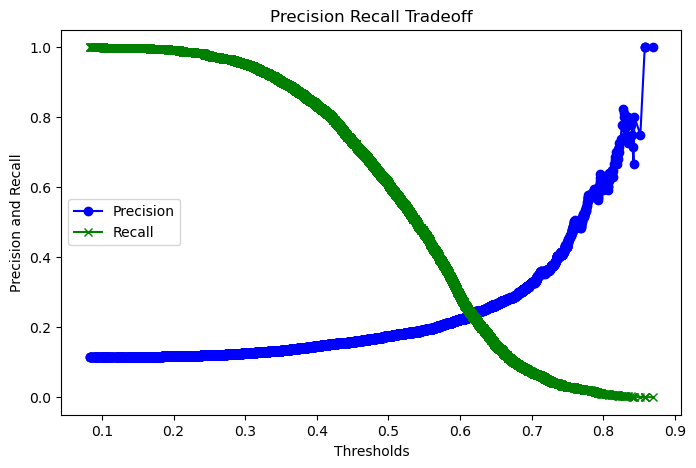

In [14]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize = (8, 5))
prec, rec, thresh = precision_recall_curve(y_test, y_test_prob)
plt.plot(thresh, prec[1:], marker = 'o', c = 'b', label = 'Precision')
plt.plot(thresh, rec[1:], marker = 'x', c = 'g', label = 'Recall')
plt.legend(loc = 'center left')
plt.xlabel("Thresholds")
plt.ylabel('Precision and Recall')
plt.title('Precision Recall Tradeoff')
plt.show()

As we increase the Recall, the precision decreases which means that if we want to reduce the number of False Negatives our False Positives will increase. 

In [15]:
acc = []
f1 = []
prec = []
rec = []
thresh = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
for i in thresh:
    pred = (y_test_prob >= i).astype(bool)
    f1.append(f1_score(y_test, pred))
    acc.append(accuracy_score(y_test, pred))
    prec.append(precision_score(y_test, pred))
    rec.append(recall_score(y_test, pred))
res = pd.DataFrame({"Thresholds" : thresh, "Accuracy" : acc, "F1" : f1, "Precision" : prec, "Recall" : rec})
res

Thresholds  Accuracy        F1  Precision    Recall
0         0.10  0.116926  0.205904   0.114776  0.999400
1         0.15  0.122832  0.206757   0.115326  0.997902
2         0.20  0.140174  0.209103   0.116866  0.992206
3         0.25  0.174960  0.213243   0.119697  0.976019
4         0.30  0.235225  0.221865   0.125569  0.951739
5         0.35  0.317056  0.232361   0.133351  0.902278
6         0.40  0.421036  0.248395   0.145894  0.835132
7         0.45  0.523849  0.259769   0.158028  0.729317
8         0.50  0.626661  0.272289   0.175284  0.609712
9         0.55  0.713780  0.272370   0.192142  0.467626
10        0.60  0.802891  0.251239   0.222402  0.288669
11        0.65  0.854881  0.190111   0.263549  0.148681
12        0.70  0.876790  0.118428   0.328338  0.072242
13        0.75  0.884551  0.055618   0.441964  0.029676
14        0.80  0.885821  0.018885   0.603774  0.009592
15        0.85  0.885547  0.002394   0.800000  0.001199

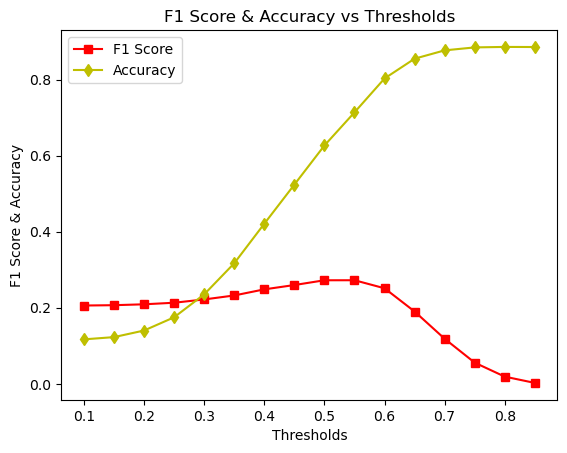

In [16]:
plt.plot(thresh, f1, marker = 's', c = 'r', label = 'F1 Score')
plt.plot(thresh, acc, marker = 'd', c = 'y', label = 'Accuracy')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score & Accuracy')
plt.title('F1 Score & Accuracy vs Thresholds')
plt.legend(loc = 'best')
plt.show()

Best Threshold=0.498919, G-Mean=0.620


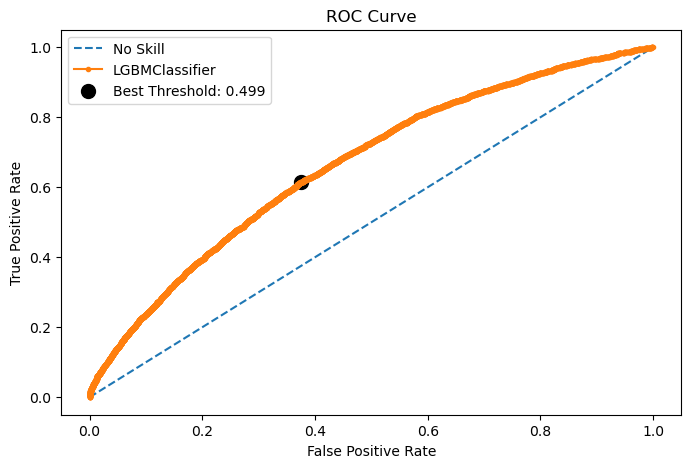

In [17]:
from sklearn.metrics import roc_curve
plt.figure(figsize = (8, 5))
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='LGBMClassifier')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', alpha = 1, edgecolors = 'k', s = 100,
            label='Best Threshold: '+str(round(thresholds[ix], 3)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend(loc = 'best')
# show the plot
plt.show()

In [18]:
y_train_pred = (y_train_prob >= 0.487).astype(bool)
y_test_pred = (y_test_prob >= 0.487).astype(bool)
print("Train Accuracy Score:", accuracy_score(y_train, y_train_pred))
print("Train Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred), '\n')
print("Train F1 Score:", f1_score(y_train, y_train_pred))
print("Train Precision Score:", precision_score(y_train, y_train_pred))
print("Train Recall Score:", recall_score(y_train, y_train_pred))
print("Train ROC_AUC Score:", roc_auc_score(y_train, y_train_prob))
print()
print("Test Accuracy Score:", accuracy_score(y_test, y_test_pred))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred), '\n')
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Test Precision Score:", precision_score(y_test, y_test_pred))
print("Test Recall Score:", recall_score(y_test, y_test_pred))
print("Test ROC_AUC Score:", roc_auc_score(y_test, y_test_prob))

Train Accuracy Score: 0.6150200885958587
Train Confusion Matrix:
 [[36156 24009]
 [ 2150  5634]] 

Train F1 Score: 0.3010660752932375
Train Precision Score: 0.19006173464224269
Train Recall Score: 0.723792394655704
Train ROC_AUC Score: 0.7283908400579462

Test Accuracy Score: 0.598605817107929
Test Confusion Matrix:
 [[15296 10489]
 [ 1200  2136]] 

Test F1 Score: 0.2676524027316584
Test Precision Score: 0.1691881188118812
Test Recall Score: 0.6402877697841727
Test ROC_AUC Score: 0.6633169787613771


### SHAP

In [19]:
pip install shap

     -------------------------------------- 435.6/435.6 kB 6.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [20]:
import shap
explainer = shap.TreeExplainer(model, data=X_train)
shap_values = explainer.shap_values(X_test)
pd.DataFrame(shap_values).head()

 99%|===================| 28892/29121 [02:07<00:01]        

0         1         2         3         4         5         6   \
0 -0.012312  0.071096  0.063750  0.025886 -0.004228 -0.032323 -0.029881   
1 -0.012012 -0.092860  0.004778  0.000147  0.031736 -0.028354 -0.057536   
2 -0.007661 -0.019694 -0.008822  0.002896  0.020177 -0.047281  0.032479   
3  0.005172  0.018569  0.054252 -0.158696 -0.149307 -0.363867  0.033909   
4  0.004519 -0.105162  0.042657  0.022582  0.003849  0.036144 -0.029926   

         7    8         9   ...        85   86        87        88        89  \
0  0.023245  0.0  0.005288  ...  0.000000  0.0  0.017329 -0.002135  0.000755   
1  0.027002  0.0  0.004431  ...  0.000000  0.0  0.003137 -0.003391  0.001273   
2  0.015530  0.0  0.013239  ...  0.000086  0.0  0.003228  0.001425  0.001240   
3  0.030829  0.0  0.003780  ...  0.000100  0.0  0.002727 -0.000692  0.001104   
4  0.000686  0.0  0.000676  ...  0.000110  0.0  0.003199 -0.000635  0.000750   

         90        91        92   93        94  
0  0.012857  0.002237 -0.025491  0.0 -0.004603  
1  0.015019  0.001850  0.070225  0.0 -0.000168  
2  0.020211  0.002151 -0.045349  0.0 -0.000716  
3 -0.002197  0.002574 -0.057572  0.0 -0.000454  
4  0.006579  0.002628 -0.015934  0.0  0.000565  

[5 rows x 95 columns]

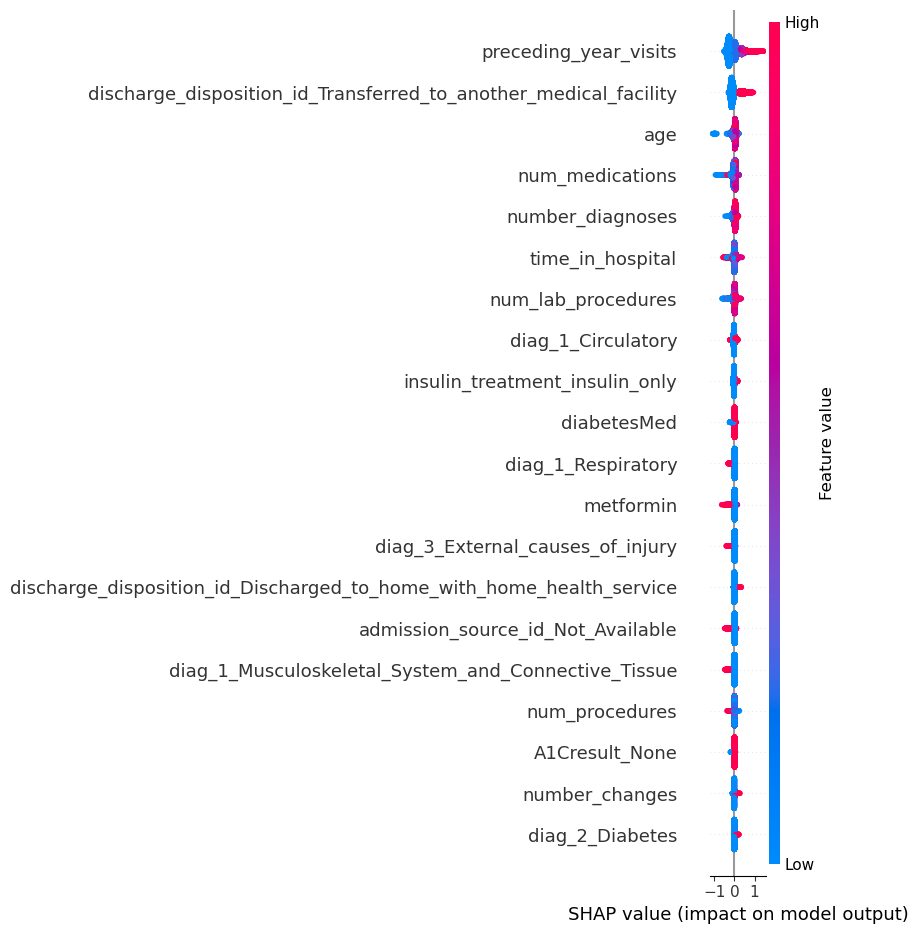

In [21]:
shap.summary_plot(shap_values, X_test)

### LIME

In [22]:
conda update -n base -c defaults conda

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\abhya\anaconda3

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-package-handling-1.9.0|   py39h8cc25b3_1         744 KB
    conda-repo-cli-1.0.24      |   py39haa95532_0         133 KB
    ------------------------------------------------------------
                                           Total:         877 KB

The following packages will be UPDATED:

  conda-package-han~                   1.9.0-py39h8cc25b3_0 --> 1.9.0-py39h8cc25b3_1 None
  conda-repo-cli                      1.0.20-py39haa95532_0 --> 1.0.24-py39haa95532_0 None




conda-repo-cli-1.0.2 | 133 KB    |            |   0% 
conda-repo-cli-1.0.2 | 133 KB    | ###6       |  36% 
conda-repo-cli-1.0.2 | 133 KB    | ########## | 100% 
conda-repo-cli-1.0.2 | 133 KB    | ########## | 100% 

c

In [23]:
conda install -c conda-forge skater

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\abhya\anaconda3

  added / updated specs:
    - skater


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    anaconda-2022.10           |          py310_0          13 KB
    ca-certificates-2022.9.24  |       h5b45459_0         189 KB  conda-forge
    certifi-2022.9.24          |     pyhd8ed1ab_0         155 KB  conda-forge
    conda-22.9.0               |   py39hcbf5309_2         985 KB  conda-forge
    dill-0.3.6                 |     pyhd8ed1ab_1          81 KB  conda-forge
    ds-lime-0.1.1.27           |             py_1         214 KB  conda-forge
    multiprocess-0.70.14       |   py39ha55989b_3         237 KB  conda-forge
    openssl-1.1.1s             |       hcfcfb64_0         5.9 MB  conda-forge
    pathos-0.3.0               |     pyhd8ed1ab_0          51 KB  conda-forge
    pox-0.3.2   

In [24]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
interpreter = Interpretation(training_data=X_train, feature_names=list(X_train.columns))
im_model = InMemoryModel(model.predict_proba, examples=X_train, unique_values=[0, 1], target_names=['Not Readmitted', 'Readmitted < 30 Days'])
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

model = LGBMClassifier(objective = 'binary', random_state = 0, n_jobs = -1, is_unbalance = True,
                       boosting_type = 'gbdt', learning_rate = 0.06475, max_depth = 178,
                       min_child_samples = 22, n_estimators = 128, num_leaves = 23)
model.fit(X_train, y_train)

exp = LimeTabularExplainer(X_test.values, feature_names=list(X_test.columns), 
                           discretize_continuous=True, 
                           class_names=['Not Readmitted', 'Readmitted < 30 Days'])

In [25]:
X_test = X_test.reset_index(drop = True )
y_test = y_test.reset_index(drop = True )

In [26]:
doc_num = 1
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', y_test_pred[doc_num].astype('int'))
exp.explain_instance(X_test.iloc[doc_num].values, 
                     model.predict_proba, 
                     num_samples=50000).show_in_notebook()

Actual Label: 0
Predicted Label: 0


In [27]:
doc_num = 5
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', y_test_pred[doc_num].astype('int'))
exp.explain_instance(X_test.iloc[doc_num].values, 
                     model.predict_proba, 
                     num_samples=50000).show_in_notebook()

Actual Label: 0
Predicted Label: 1


In [28]:
doc_num = 200
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', y_test_pred[doc_num].astype('int'))
exp.explain_instance(X_test.iloc[doc_num].values, 
                     model.predict_proba, 
                     num_samples=50000).show_in_notebook()

Actual Label: 1
Predicted Label: 1
